In [135]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

root_dir = r"C:\Users\Acer\Desktop\2024\học sâu\Yeast\data\data_single_cell"

# Danh sách (img_path, label)
all_pairs = []

folders = glob.glob(os.path.join(root_dir, "*"))
for folder in folders:
    if not os.path.isdir(folder):
        continue

    excel_file = None
    for f in os.listdir(folder):
        if f.endswith(".xlsx"):
            excel_file = os.path.join(folder, f)
            break
    if excel_file is None:
        print(f"Không tìm thấy file Excel trong {folder}")
        continue

    df = pd.read_excel(excel_file, header=1)
    df = df.iloc[:-1]
    df.columns = df.columns.str.strip()

    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].astype(str).str.strip()

    if "FP" in df.columns:
        df["FP"] = pd.to_numeric(df["FP"], errors="coerce")
    if "Cụm tế bào" in df.columns:
        df["Cụm tế bào"] = pd.to_numeric(df["Cụm tế bào"], errors="coerce")

    def get_label(row):
        if "FP" in row and pd.notna(row["FP"]) and row["FP"] > 0:
            return None
        if "Cụm tế bào" in row and pd.notna(row["Cụm tế bào"]) and row["Cụm tế bào"] > 1:
            return None
        if "Normal" in row and row["Normal"] == 1:
            return 0
        elif "Abnormal" in row and row["Abnormal"] == 1:
            return 1
        else:
            return None

    df["Label"] = df.apply(get_label, axis=1)

    for i, row in df.iterrows():
        label = row["Label"]
        if pd.isna(label):
            continue
        img_id = str(row["id"])
        img_path = os.path.join(folder, img_id + ".png")
        if not os.path.exists(img_path):
            print(f"[Warning] Không tìm thấy ảnh: {img_path}")
            continue
        all_pairs.append((img_path, label))

print("Tổng số ảnh:", len(all_pairs))
print("Ví dụ 5 cặp đầu:", all_pairs[:5])

train, dev = train_test_split(all_pairs, test_size=0.2, random_state=42)
print("Train size:", len(train))
print("Dev size:", len(dev))

# Định nghĩa các transform
train_transform = T.Compose([
    T.CenterCrop((32, 32)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dev_transform = T.Compose([
    T.CenterCrop((32, 32)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Định nghĩa Dataset tùy biến
class YeastDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img_path, label = self.pairs[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Tạo dataset
train_dataset = YeastDataset(train, transform=train_transform)
dev_dataset   = YeastDataset(dev,   transform=dev_transform)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=0)
dev_loader   = DataLoader(dev_dataset,   batch_size=16, shuffle=False, num_workers=0)

print("Số batch trong train_loader:", len(train_loader))
print("Số batch trong dev_loader:", len(dev_loader))


Tổng số ảnh: 3347
Ví dụ 5 cặp đầu: [('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\data_single_cell\\D1-B1-10H-11\\D1-B1-10H-11_1.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\data_single_cell\\D1-B1-10H-11\\D1-B1-10H-11_2.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\data_single_cell\\D1-B1-10H-11\\D1-B1-10H-11_3.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\data_single_cell\\D1-B1-10H-11\\D1-B1-10H-11_4.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\data_single_cell\\D1-B1-10H-11\\D1-B1-10H-11_5.png', 1.0)]
Train size: 2677
Dev size: 670
Số batch trong train_loader: 168
Số batch trong dev_loader: 42


In [136]:
from collections import Counter

labels = [label for _, label in all_pairs]  # Tách riêng nhãn
label_counts = Counter(labels)              # Đếm tần suất mỗi nhãn

print("Số mẫu nhãn 0:", label_counts[0])
print("Số mẫu nhãn 1:", label_counts[1])


Số mẫu nhãn 0: 975
Số mẫu nhãn 1: 2372


In [137]:
import os
import glob
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

import pandas as pd
import os
import glob

root_dir = r"C:\Users\Acer\Desktop\2024\học sâu\Yeast\data\test"
test = []

folders = glob.glob(os.path.join(root_dir, "*"))
for folder in folders:
    if not os.path.isdir(folder):
        continue

    folder_name = os.path.basename(folder)

    excel_file = None
    for f in os.listdir(folder):
        if f.endswith(".xlsx"):
            excel_file = os.path.join(folder, f)
            break
    if excel_file is None:
        print(f"Không tìm thấy file Excel trong {folder}")
        continue

    df = pd.read_excel(excel_file)
    df = df.iloc[:-1]
    df.columns = df.columns.str.strip()

    df["Tuân check"] = df["Tuân check"].astype(str).str.strip()  # ép kiểu và loại bỏ khoảng trắng

    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].astype(str).str.strip()

    def get_label(row):
        if row["Tuân check"] == "tạp":
            return None
        if row["Tuân check"] == "cụm tế bào":
            return None
        if row["Tuân check"] == "normal":
            return 0
        elif row["Tuân check"] == "abnormal":
            return 1
        else:
            return None

    df["Tuân check"] = df.apply(get_label, axis=1)
    df["cell_id"] = pd.to_numeric(df["cell_id"], errors="coerce") 
    df["cell_id"] = df["cell_id"].astype(str)

    # Duyệt qua từng dòng và tạo cặp (img_path, label)
    for i, row in df.iterrows():
        label = row["Tuân check"]
        if pd.isna(label):
            continue

        img_id = str(row["cell_id"])  # ID chỉ là số
        img_path = os.path.join(folder, f"{folder_name}_{img_id}.png")  # Tạo tên ảnh theo tên thư mục và ID
        if not os.path.exists(img_path):
            print(f"[Warning] Không tìm thấy ảnh: {img_path}")
            continue

        test.append((img_path, label))

print("Tổng số ảnh:", len(test))
print("Ví dụ 5 cặp đầu:", test[:10])

test_transform = T.Compose([
    T.CenterCrop((32, 32)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Tạo Dataset cho test
class YeastDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, label = self.pairs[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

test_dataset = YeastDataset(test, transform=test_transform)

# Tạo DataLoader cho test
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
print("Số batch trong test_loader:", len(test_loader))


Tổng số ảnh: 1148
Ví dụ 5 cặp đầu: [('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_1.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_2.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_3.png', 0.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_4.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_5.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_6.png', 0.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_7.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_8.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_10.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data

In [138]:
from collections import Counter

labels = [label for _, label in test]  # Tách riêng nhãn
label_counts = Counter(labels)              # Đếm tần suất mỗi nhãn

print("Số mẫu nhãn 0:", label_counts[0])
print("Số mẫu nhãn 1:", label_counts[1])


Số mẫu nhãn 0: 379
Số mẫu nhãn 1: 769


In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1  # Không thay đổi số kênh đầu ra

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,       padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            # Thay đổi kích thước (hoặc số kênh) của shortcut
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [140]:
import torch.nn as nn
import torch.nn.functional as F

class ResNetCIFAR(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2, dropout_rate=0.5):
        super(ResNetCIFAR, self).__init__()
        self.in_planes = 16  # Số kênh ban đầu
        self.dropout_rate = dropout_rate

        # Lớp conv ban đầu
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(16)

        # Tạo các stage
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)  # giữ nguyên kích thước
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)  # giảm 1/2
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)  # giảm 1/2

        # Dropout trước lớp Fully Connected
        self.dropout = nn.Dropout(p=self.dropout_rate)

        # Cuối cùng
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_block, stride):
        """Tạo 1 stage gồm nhiều block."""
        layers = []
        # Block đầu tiên trong stage, có thể giảm kích thước
        layers.append(block(self.in_planes, planes, stride=stride))
        self.in_planes = planes
        # Các block còn lại
        for _ in range(num_block - 1):
            layers.append(block(planes, planes, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # conv1
        out = self.layer1(out)                # stage 1
        out = self.layer2(out)                # stage 2
        out = self.layer3(out)                # stage 3

        # Global Average Pooling
        out = F.avg_pool2d(out, out.size()[2])  # kernel_size = kích thước spatial
        out = out.view(out.size(0), -1)         # Flatten

        # Dropout trước lớp Fully Connected
        
        out = self.dropout(out)
        out = self.linear(out)                  # Dense => 2 lớp (mặc định)
        return out

def ResNet20(num_classes=2):
    """ResNet-20 cho ảnh 32x32, 3 stage, mỗi stage 3 block."""
    return ResNetCIFAR(block=BasicBlock, num_blocks=[3, 3, 3], num_classes=num_classes)

In [141]:
import torch.optim as optim
import torch.nn as nn

# Số liệu mẫu: Nhãn 0: 975, Nhãn 1: 2372
count0 = 975
count1 = 2372
total = count0 + count1  # 3347
num_classes = 2

w0 = total / (num_classes * count0)  # khoảng 1.7169
w1 = total / (num_classes * count1)  # khoảng 0.7057

weights = torch.tensor([w0, w1]).float().to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = ResNet20(num_classes=2).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler: giảm learning rate khi validation loss không cải thiện
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

Using device: cpu


C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [142]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)

        # Reset gradient
        optimizer.zero_grad()
        # Forward
        outputs = model(images)
        # Tính loss
        loss = criterion(outputs, labels)
        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # Tính độ chính xác
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = 100. * correct / total
    return epoch_loss, epoch_acc


In [143]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total
    val_acc  = 100. * correct / total
    return val_loss, val_acc


Epoch [1/50] Train Loss: 0.6659, Train Acc: 65.22% Val Loss: 6.3158, Val Acc: 70.00%
Best model saved at epoch 1
Epoch [2/50] Train Loss: 0.5366, Train Acc: 70.71% Val Loss: 0.5311, Val Acc: 65.97%
Best model saved at epoch 2
Epoch [3/50] Train Loss: 0.4588, Train Acc: 77.59% Val Loss: 0.5500, Val Acc: 76.87%
Epoch [4/50] Train Loss: 0.4485, Train Acc: 79.23% Val Loss: 0.9098, Val Acc: 76.87%
Epoch [5/50] Train Loss: 0.4217, Train Acc: 81.92% Val Loss: 0.5383, Val Acc: 84.33%
Epoch [6/50] Train Loss: 0.3970, Train Acc: 82.85% Val Loss: 0.5131, Val Acc: 85.67%
Best model saved at epoch 6
Epoch [7/50] Train Loss: 0.3887, Train Acc: 83.68% Val Loss: 0.4057, Val Acc: 81.34%
Best model saved at epoch 7
Epoch [8/50] Train Loss: 0.3745, Train Acc: 83.49% Val Loss: 0.3886, Val Acc: 85.52%
Best model saved at epoch 8
Epoch [9/50] Train Loss: 0.3498, Train Acc: 84.27% Val Loss: 0.4095, Val Acc: 87.01%
Epoch [10/50] Train Loss: 0.3733, Train Acc: 84.20% Val Loss: 0.3774, Val Acc: 86.72%
Best mode

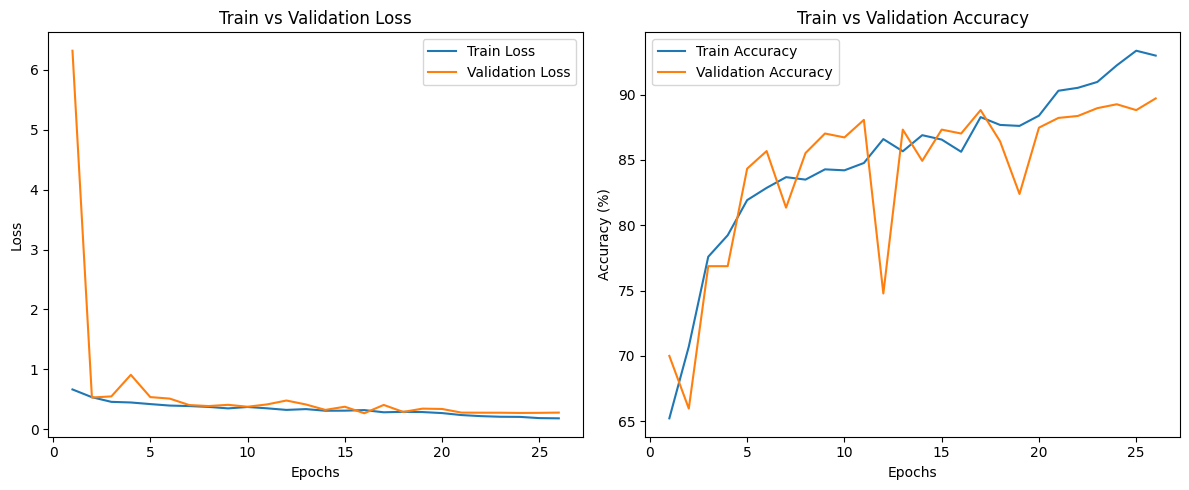

Best model loaded for testing.


In [144]:
import matplotlib.pyplot as plt
import torch

num_epochs = 50
patience = 10  # Số epoch không cải thiện trước khi dừng
best_val_loss = float('inf')
early_stop_counter = 0
best_model_path = r"C:\Users\Acer\Desktop\2024\học sâu\Yeast\resnet20best.pth"

# Lưu lại lịch sử loss và accuracy
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, dev_loader, criterion, device)

    # Lưu giá trị vào history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Kiểm tra cải thiện trên tập validation
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        # Lưu mô hình tốt nhất
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1}")
    else:
        early_stop_counter += 1
        
    scheduler.step(val_loss)

    # Dừng sớm nếu không cải thiện
    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

# Vẽ đồ thị loss và accuracy
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

# Vẽ đồ thị Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

# Vẽ đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Load mô hình tốt nhất để dự đoán tập test
model.load_state_dict(torch.load(best_model_path))
model.eval()
print("Best model loaded for testing.")

In [145]:
import torch.nn.functional as F
from PIL import Image

def predict_single_image(model, image_path, transform, device):
    model.eval()

    # Mở ảnh, chuyển sang RGB
    image = Image.open(image_path).convert("RGB")

    # Áp dụng transform (CenterCrop(32,32), ToTensor, Normalize, ...)
    image_tensor = transform(image)

    # Thêm chiều batch (1, C, H, W)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Không tính gradient khi dự đoán
    with torch.no_grad():
        output = model(image_tensor)          # output có shape (1, 2) cho 2 lớp
        probs = F.softmax(output, dim=1)      # chuyển sang xác suất
        pred = probs.argmax(dim=1).item()     # chỉ số lớp dự đoán (0 hoặc 1)

    # 0 => Bình thường, 1 => Bất thường (tuỳ logic của bạn)
    label_str = "Bình thường" if pred == 0 else "Bất thường"
    confidence = probs[0][pred].item()       # Xác suất của lớp dự đoán
    return label_str, confidence


In [146]:
import torch
import torch.nn.functional as F
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.eval()  # Chuyển sang chế độ eval



def predict_single_image(model, image_path, transform, device):
    """
    Hàm dự đoán 1 ảnh nấm men là bình thường (0) hay bất thường (1).
    Trả về (label_str, confidence).
    """
    model.eval()  # Đảm bảo chế độ eval
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # Thêm batch dimension

    with torch.no_grad():
        output = model(image_tensor)           # shape (1, 2)
        probs = F.softmax(output, dim=1)       # chuyển sang xác suất
        pred = probs.argmax(dim=1).item()      # 0 hoặc 1
    # Suy ra tên lớp
    label_str = "Bình thường" if pred == 0 else "Bất thường"
    confidence = probs[0][pred].item()        # Xác suất của lớp dự đoán
    return label_str, confidence



Using device: cpu


In [147]:
import torch.nn.functional as F

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)          # shape (batch_size, 2)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            # Lấy dự đoán
            _, predicted = outputs.max(dim=1)
            total_correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = running_loss / total_samples
    accuracy = 100.0 * total_correct / total_samples
    return avg_loss, accuracy


In [148]:
criterion = nn.CrossEntropyLoss()  # giống lúc train
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Test Loss: 0.3838, Test Acc: 83.54%


In [149]:
model.eval()
predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        # Lấy lớp dự đoán
        _, preds = outputs.max(dim=1)
        predictions.extend(preds.cpu().tolist())

print("Dự đoán:", predictions)


Dự đoán: [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 

In [150]:
from collections import Counter

count_preds = Counter(predictions)

print(f"Số lượng 0: {count_preds[0]}")
print(f"Số lượng 1: {count_preds[1]}")


Số lượng 0: 284
Số lượng 1: 864


In [151]:
from collections import Counter

labels = [label for _, label in test_dataset]  # Lấy danh sách tất cả nhãn
label_counts = Counter(labels)  # Đếm số lượng từng nhãn

print(f"Số lượng mẫu nhãn 0: {label_counts[0]}")
print(f"Số lượng mẫu nhãn 1: {label_counts[1]}")




Số lượng mẫu nhãn 0: 0
Số lượng mẫu nhãn 1: 0


In [152]:
from collections import Counter

labels = [label for _, label in train_dataset]  # Lấy danh sách tất cả nhãn
label_counts = Counter(labels)  # Đếm số lượng từng nhãn

print(f"Số lượng mẫu nhãn 0: {label_counts[0]}")
print(f"Số lượng mẫu nhãn 1: {label_counts[1]}")




Số lượng mẫu nhãn 0: 774
Số lượng mẫu nhãn 1: 1903


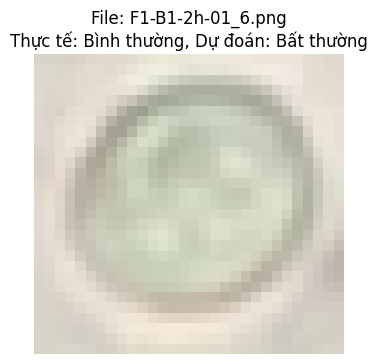

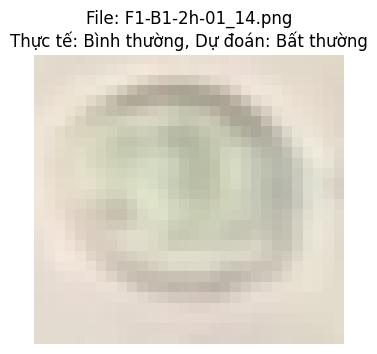

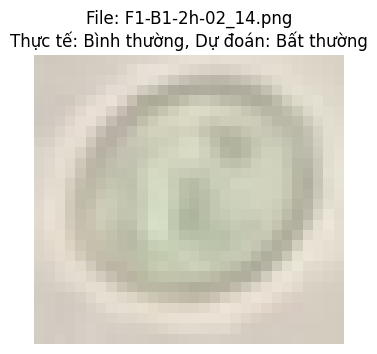

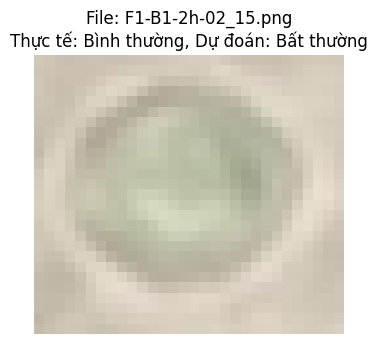

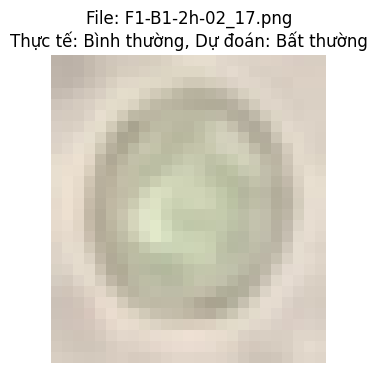

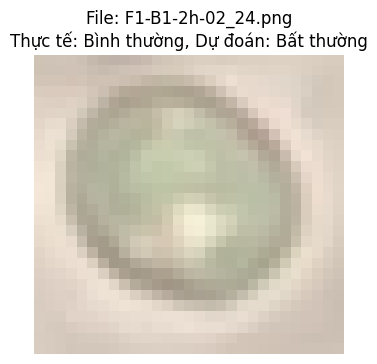

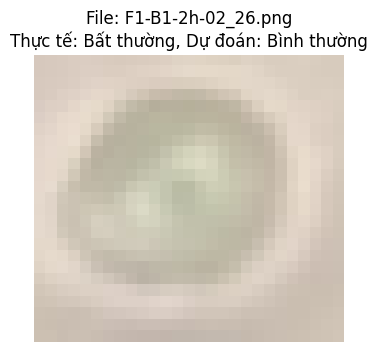

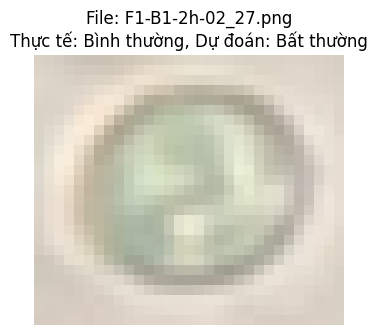

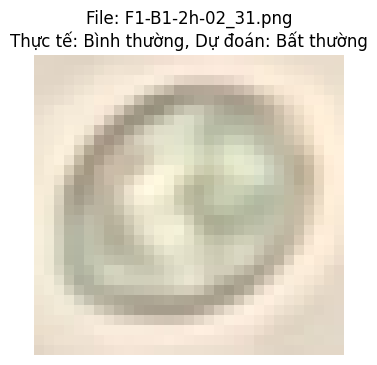

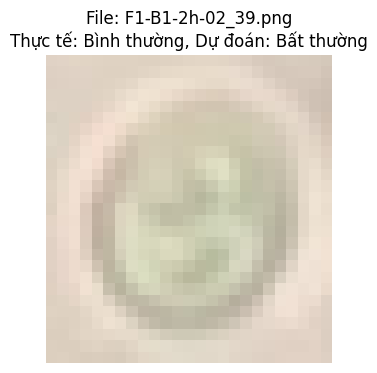

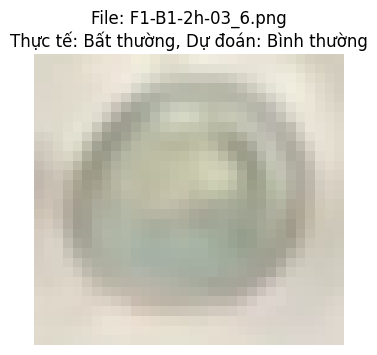

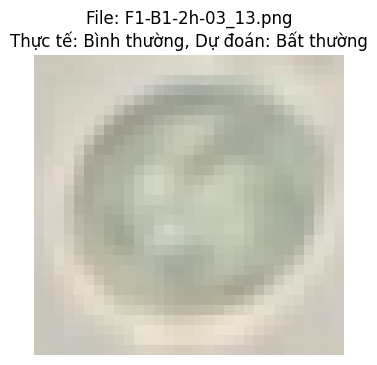

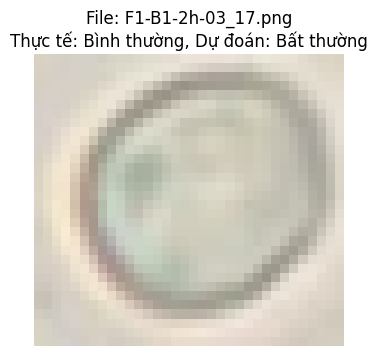

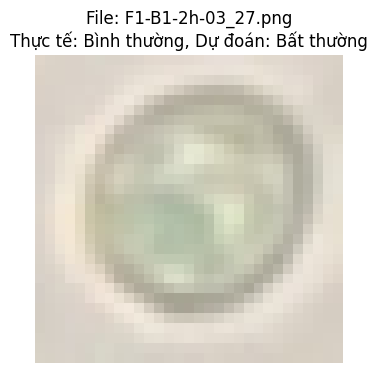

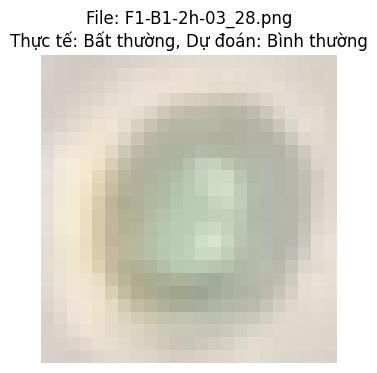

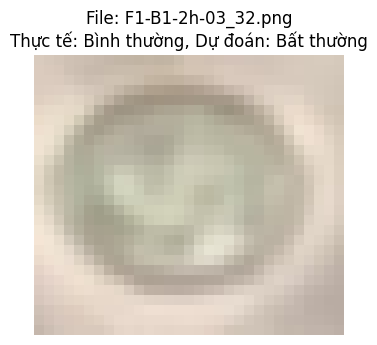

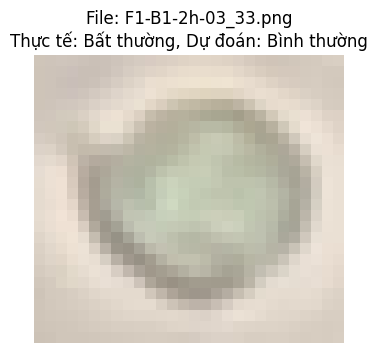

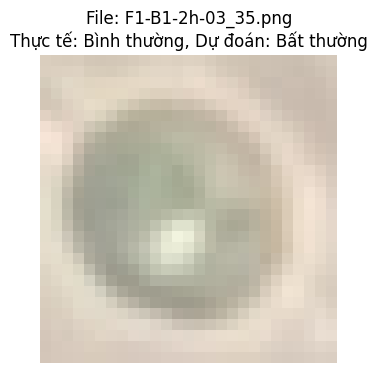

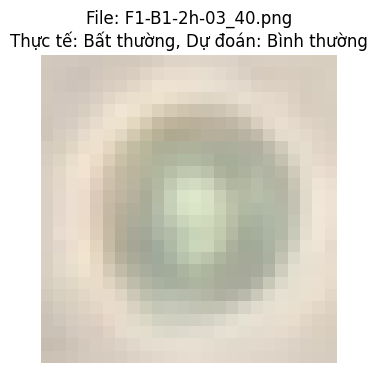

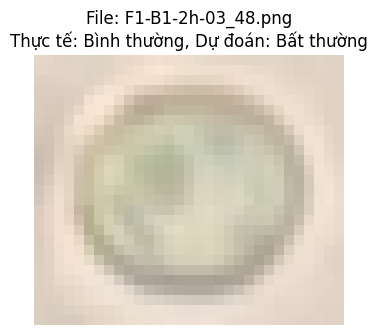

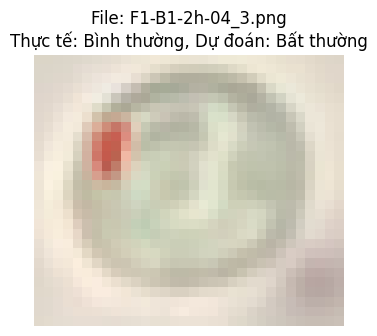

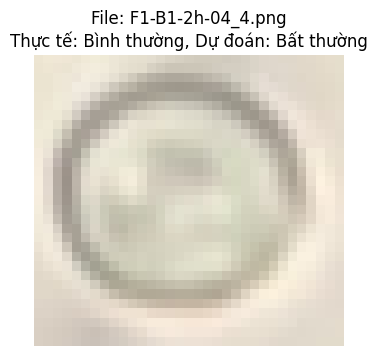

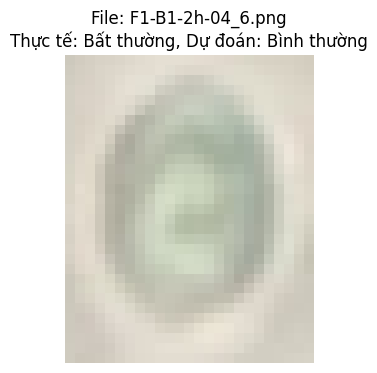

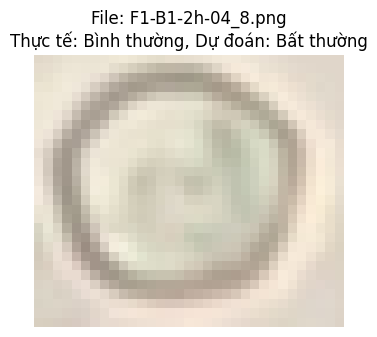

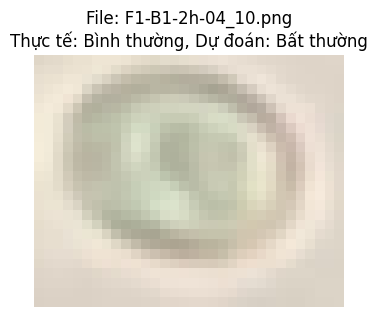

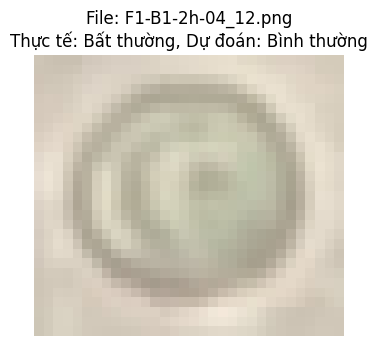

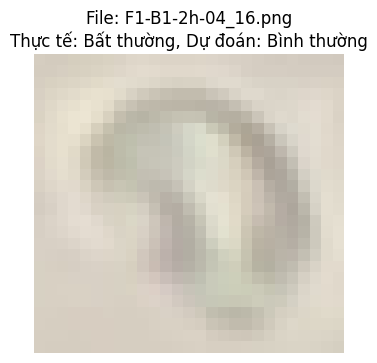

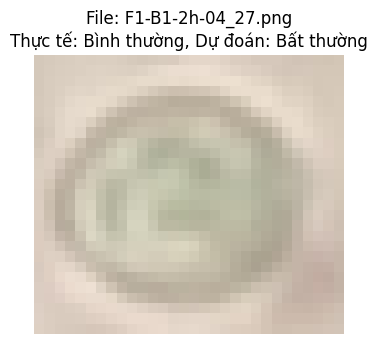

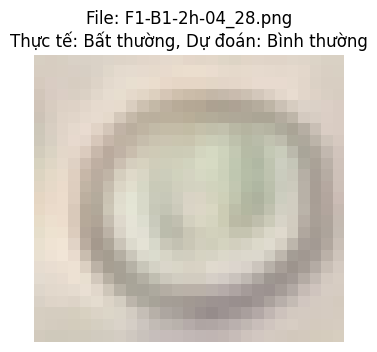

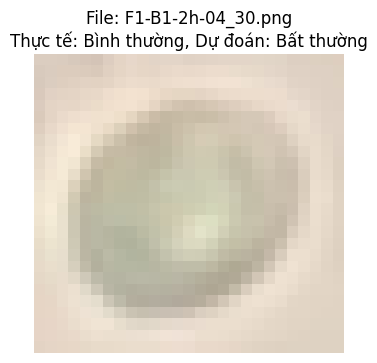

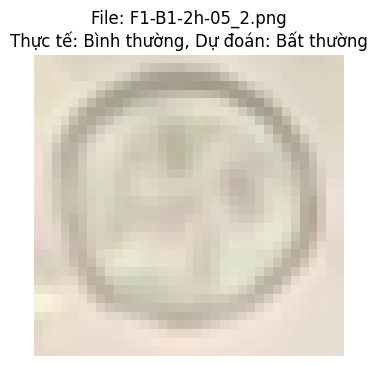

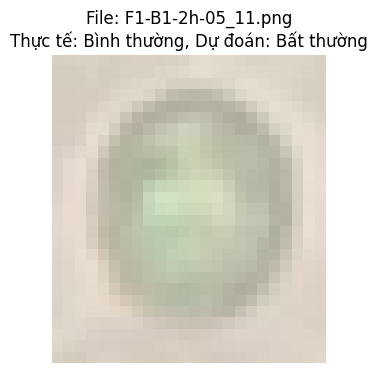

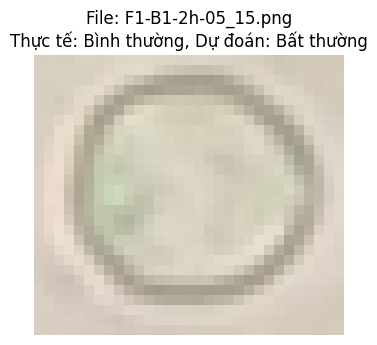

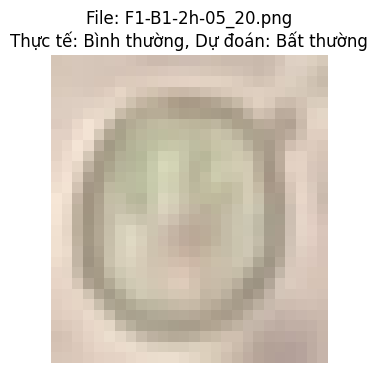

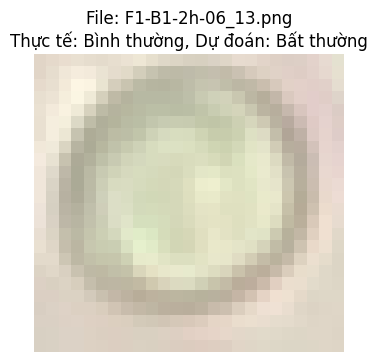

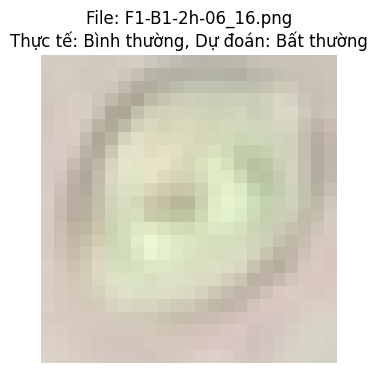

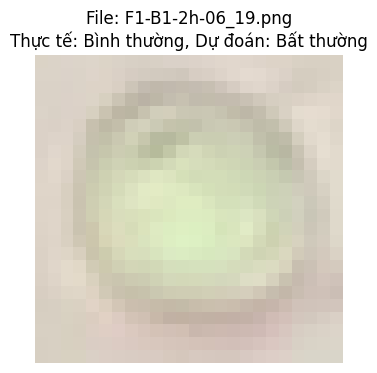

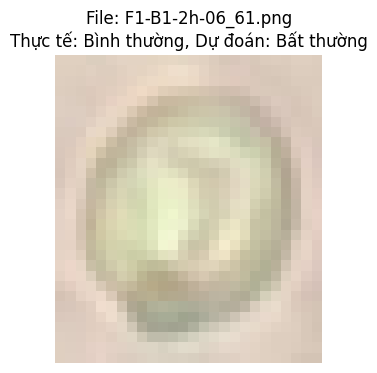

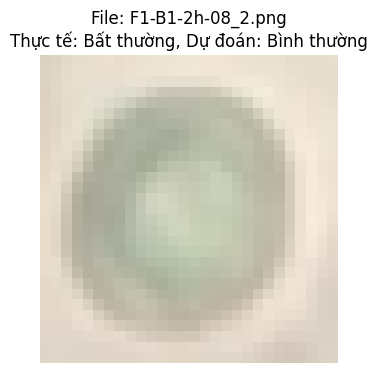

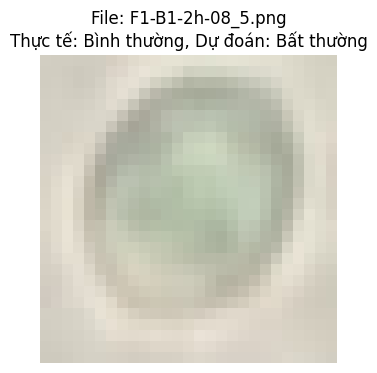

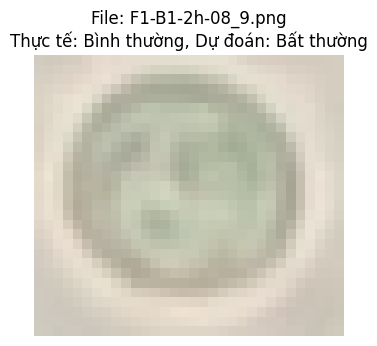

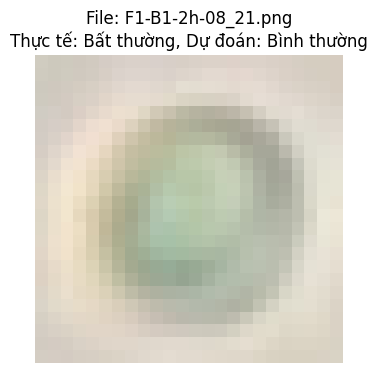

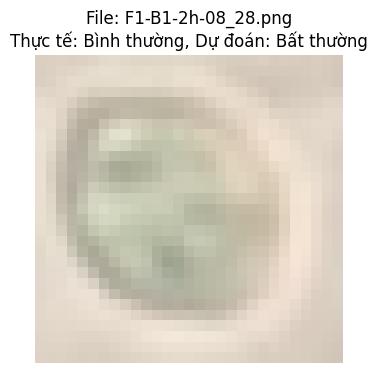

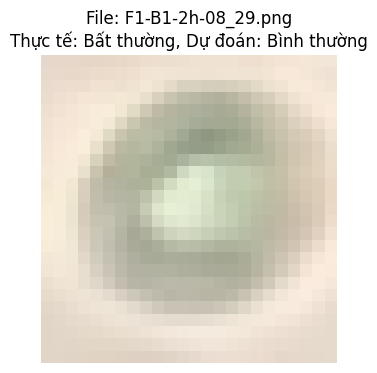

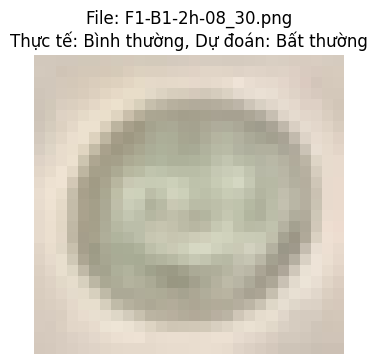

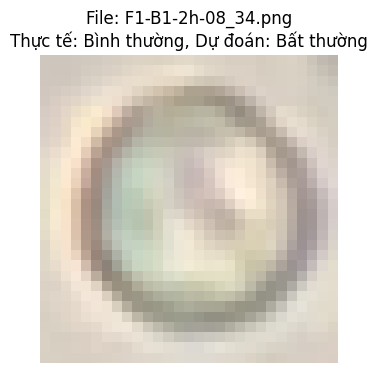

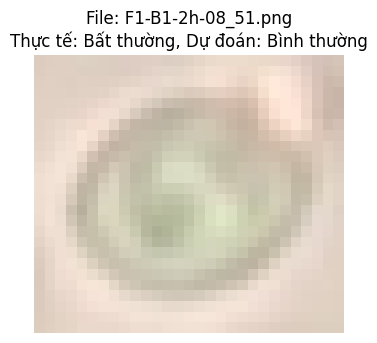

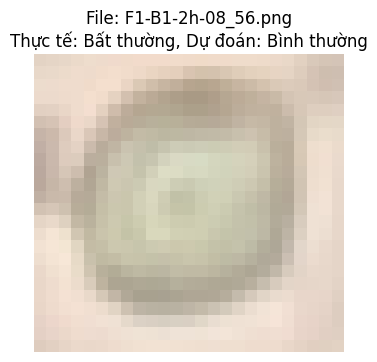

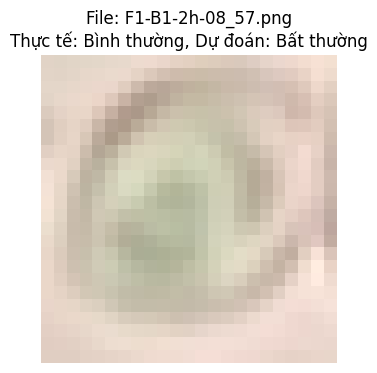

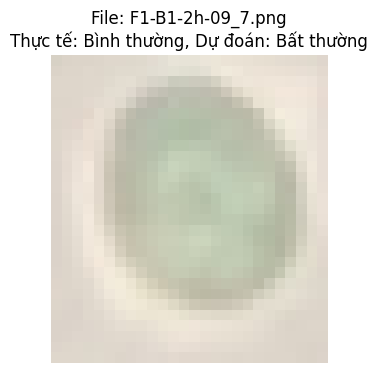

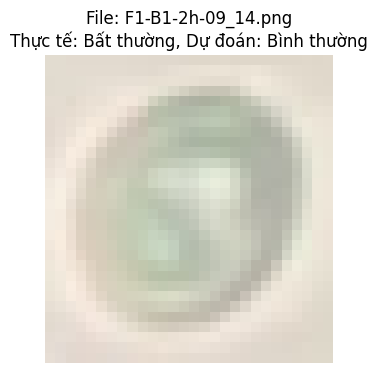

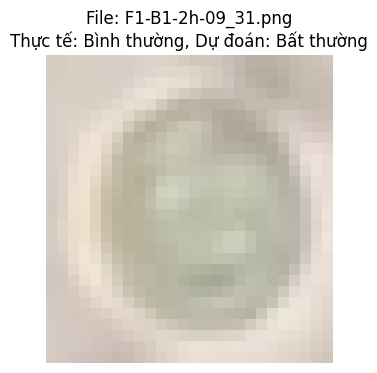

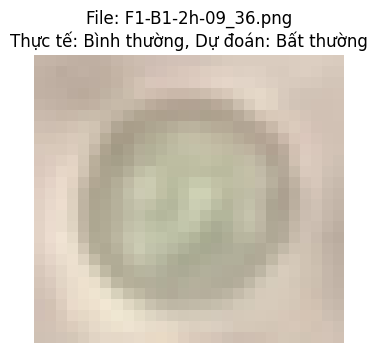

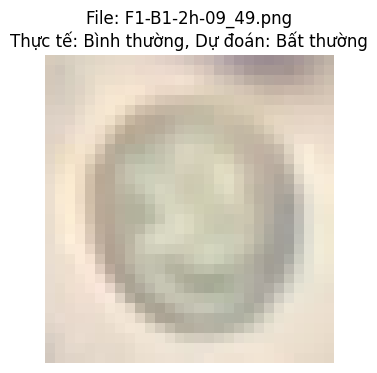

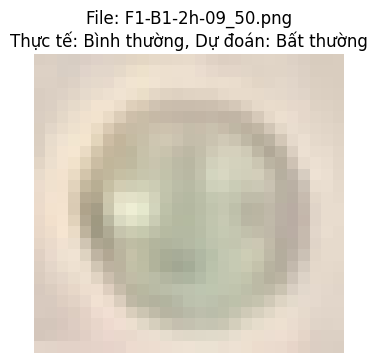

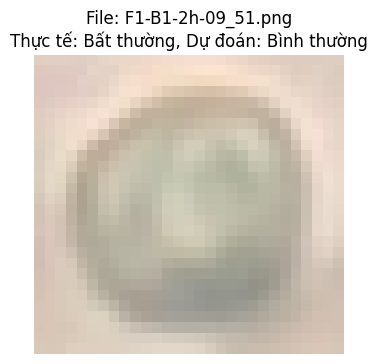

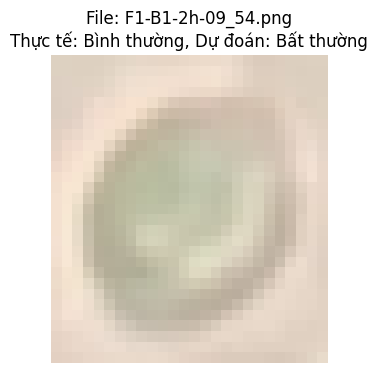

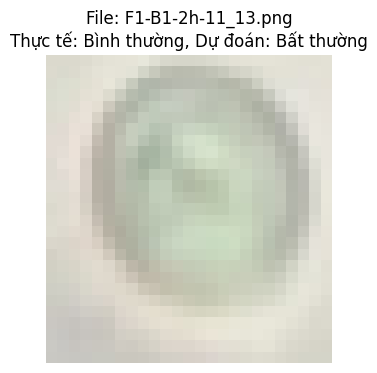

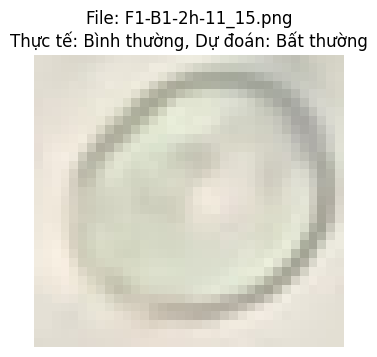

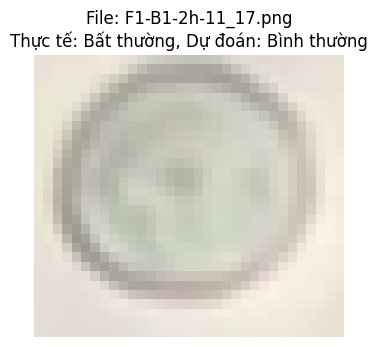

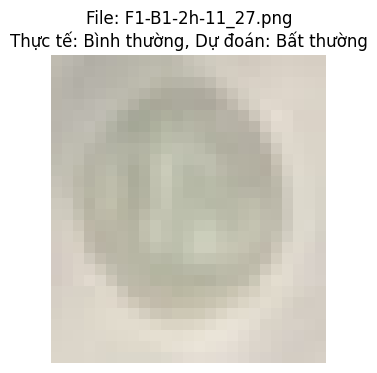

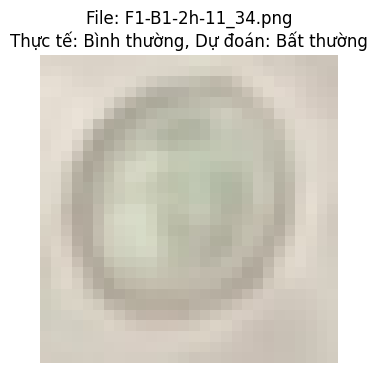

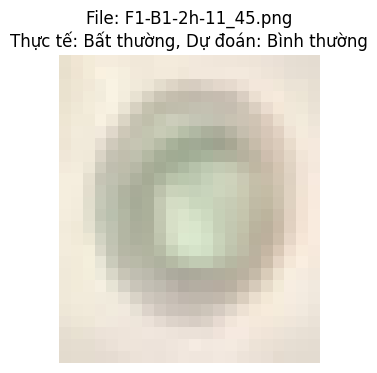

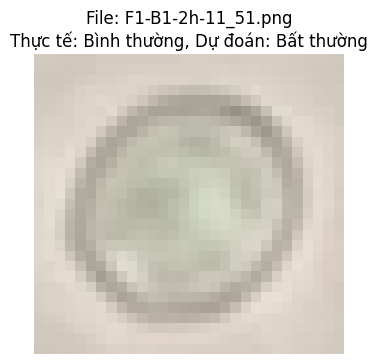

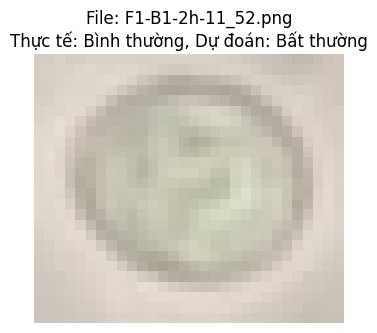

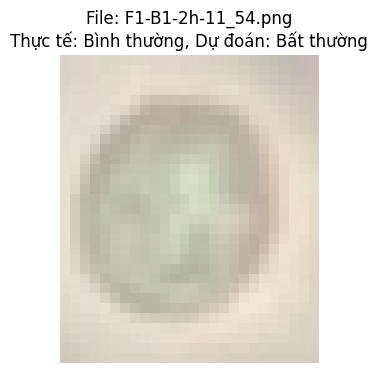

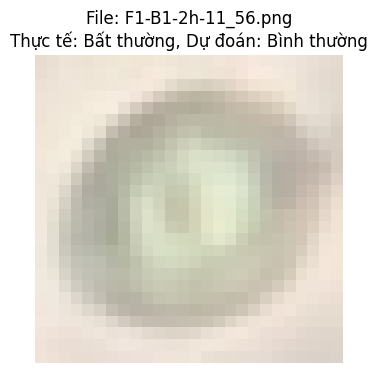

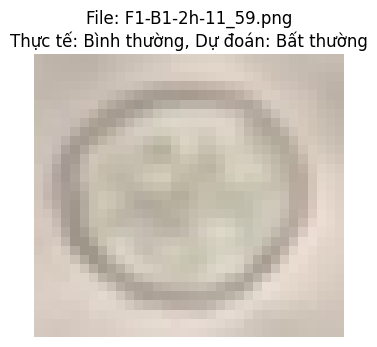

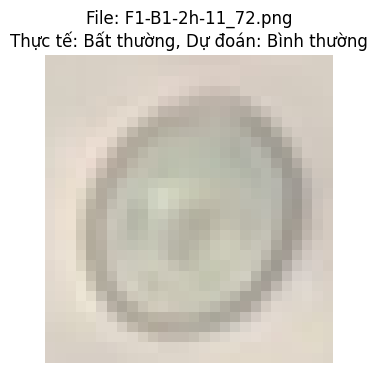

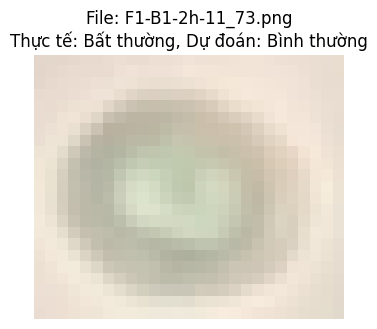

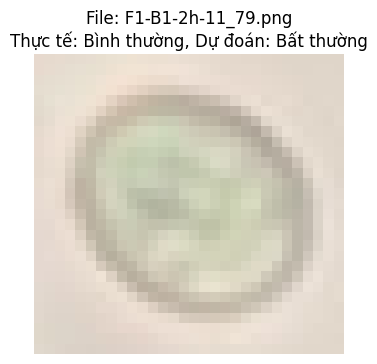

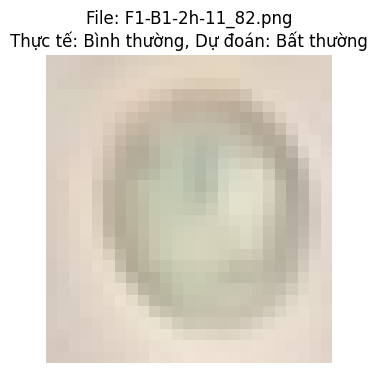

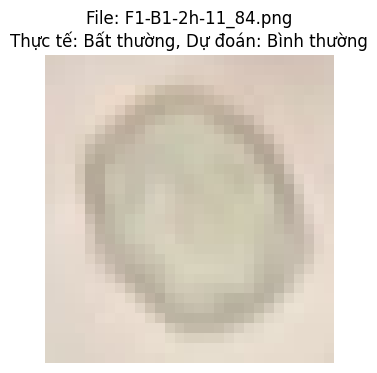

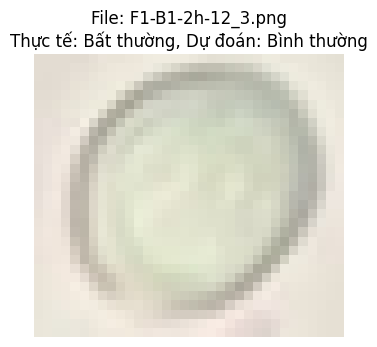

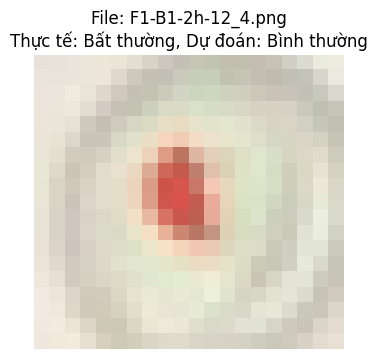

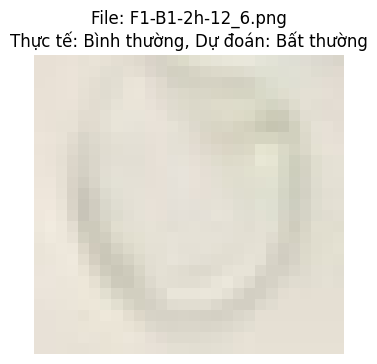

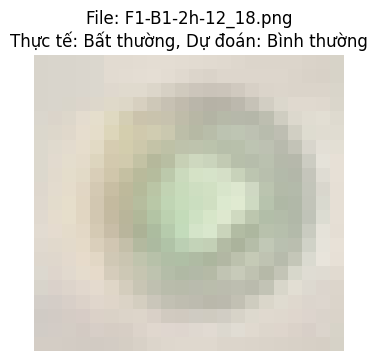

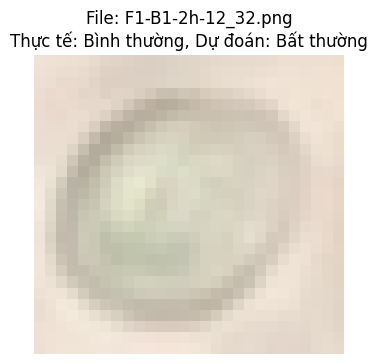

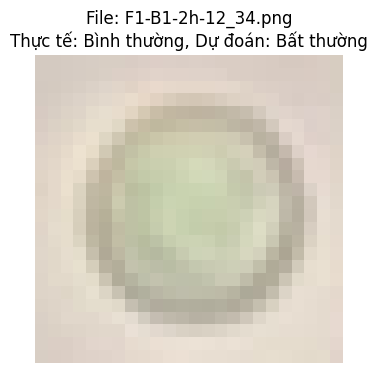

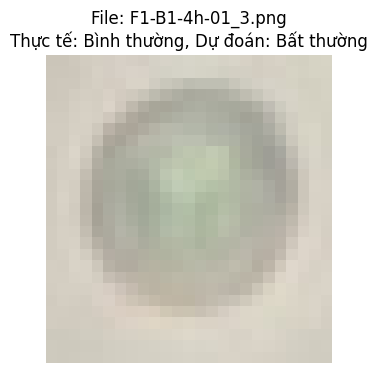

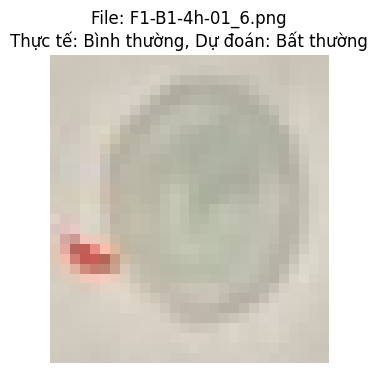

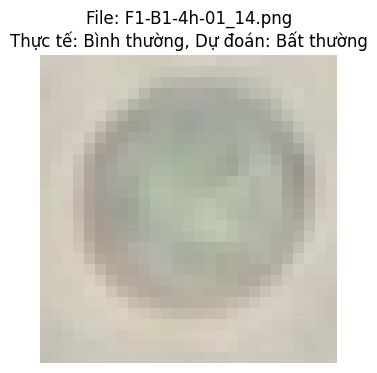

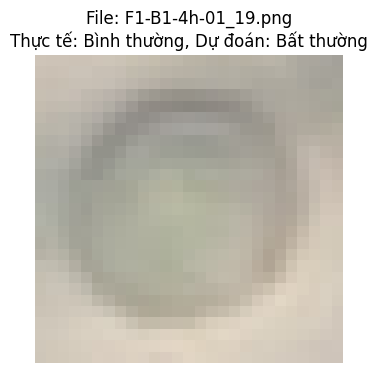

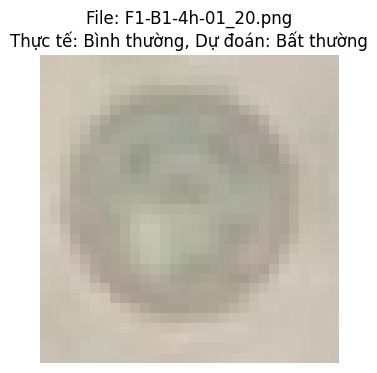

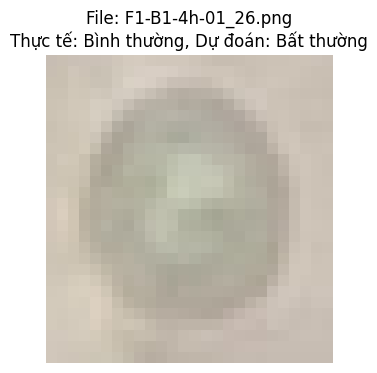

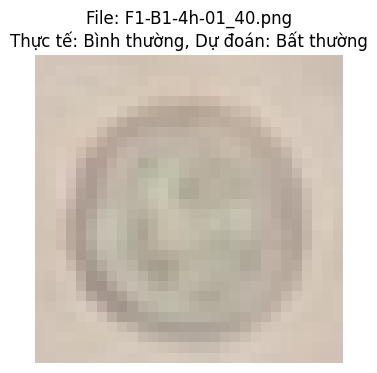

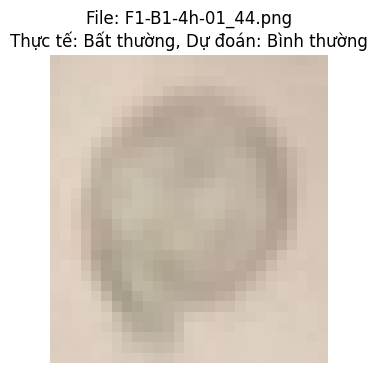

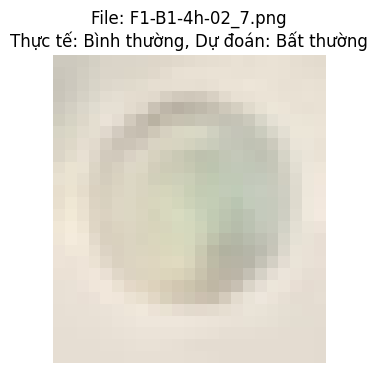

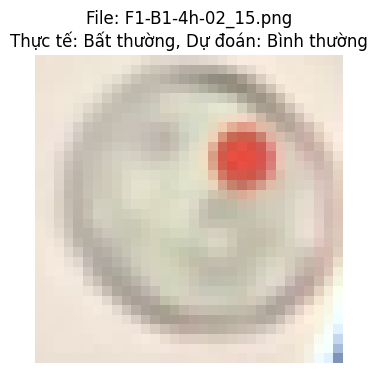

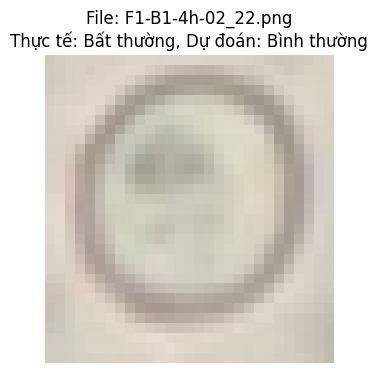

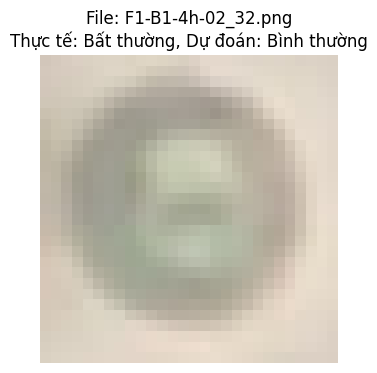

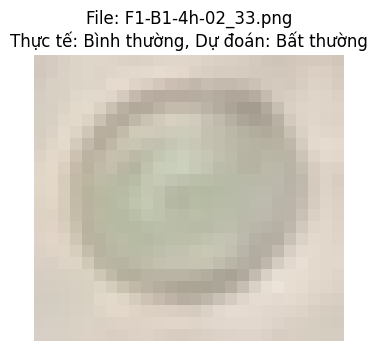

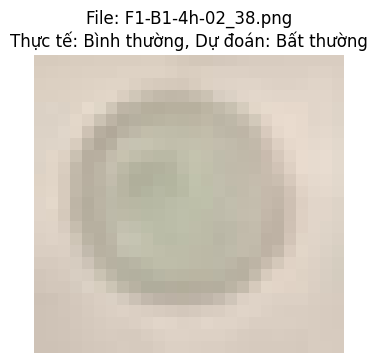

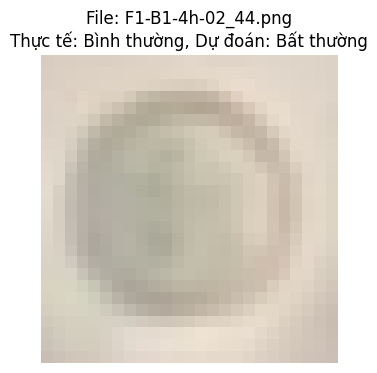

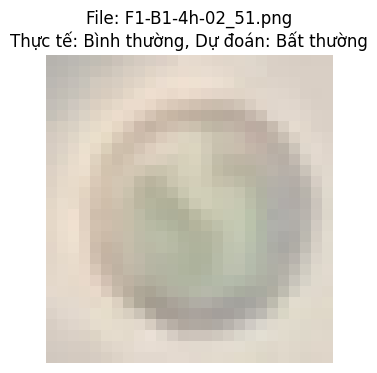

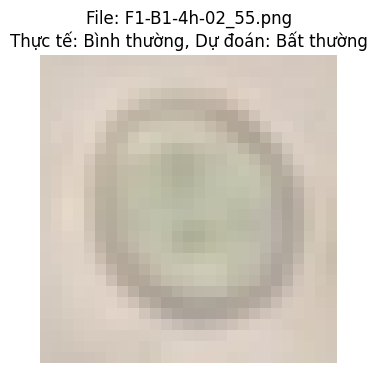

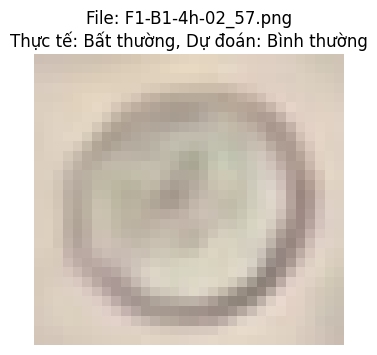

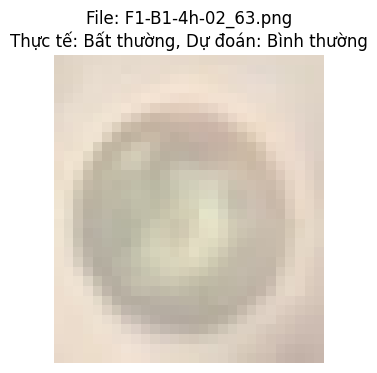

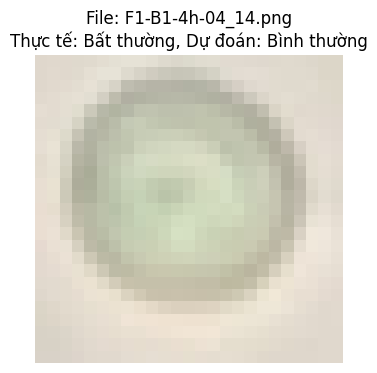

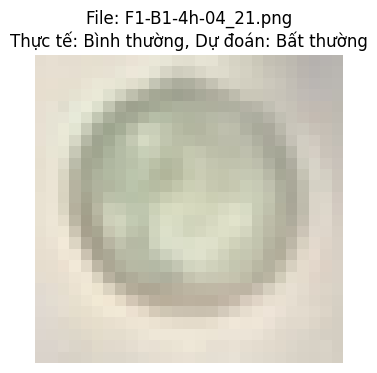

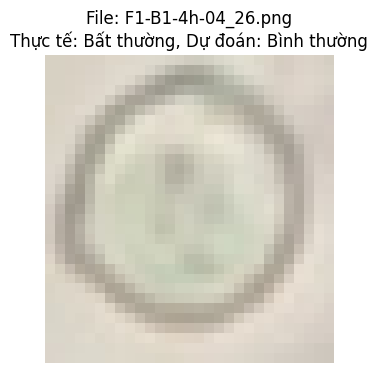

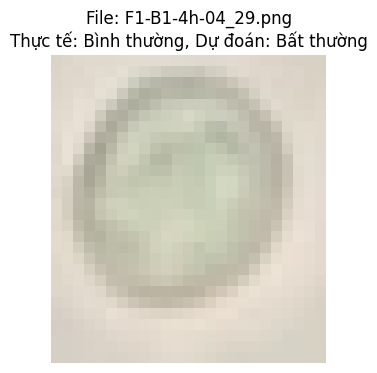

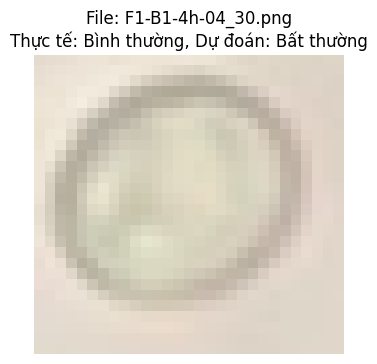

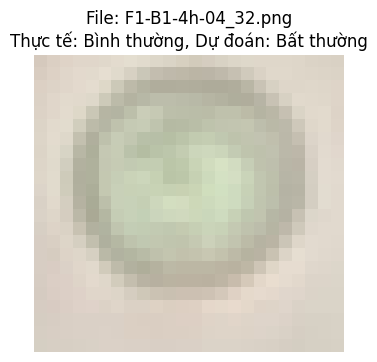

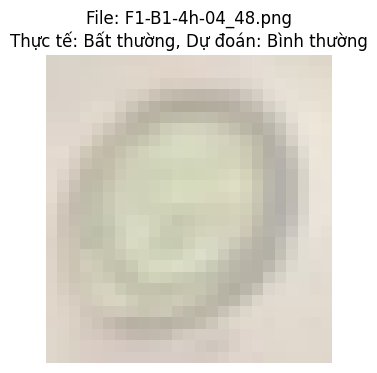

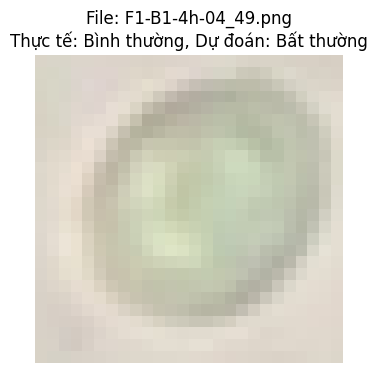

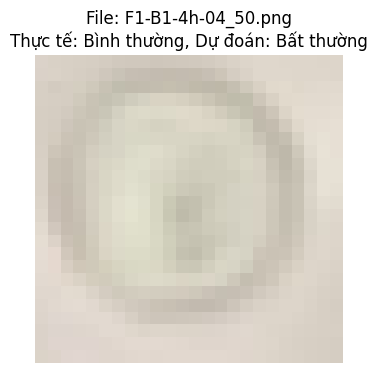

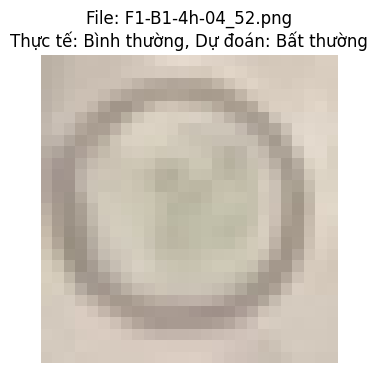

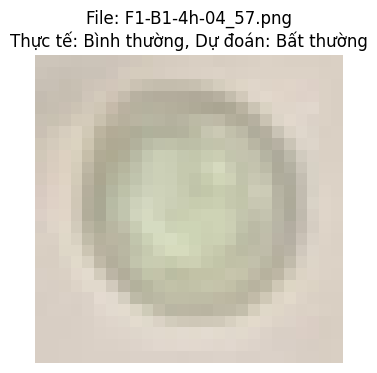

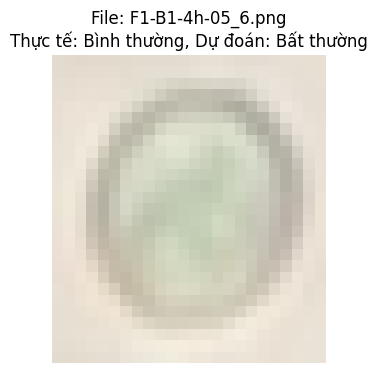

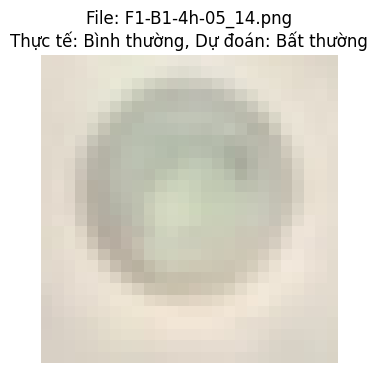

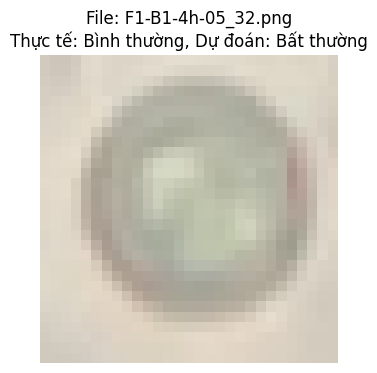

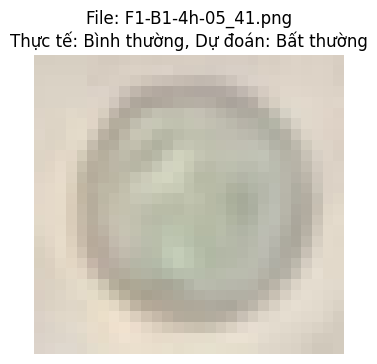

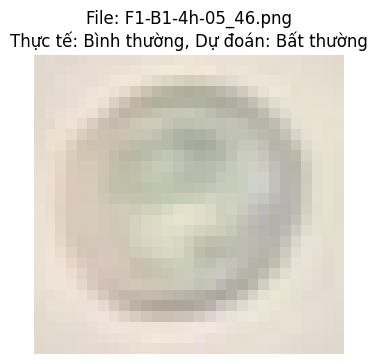

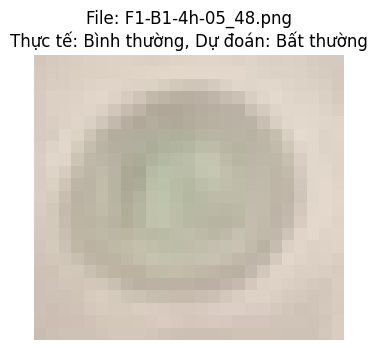

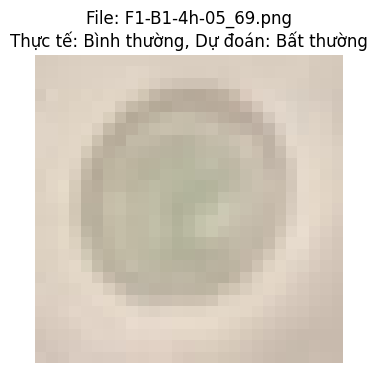

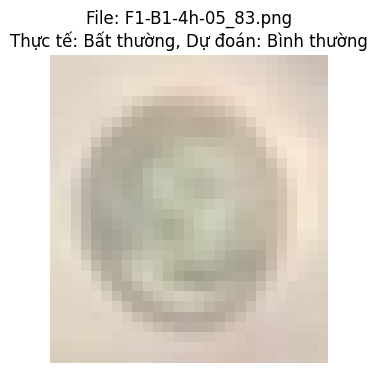

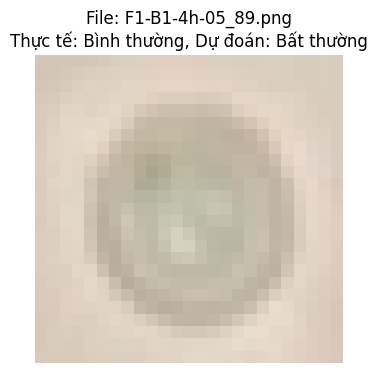

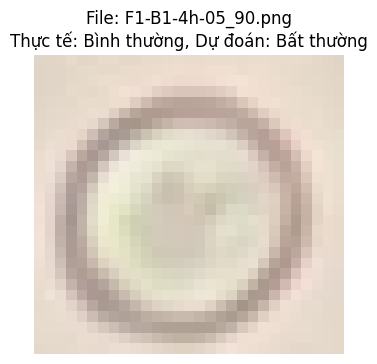

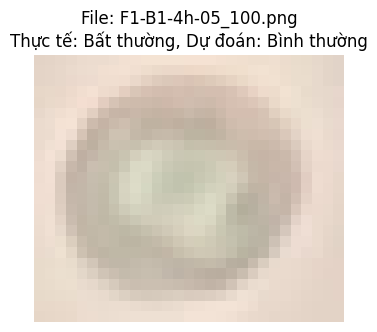

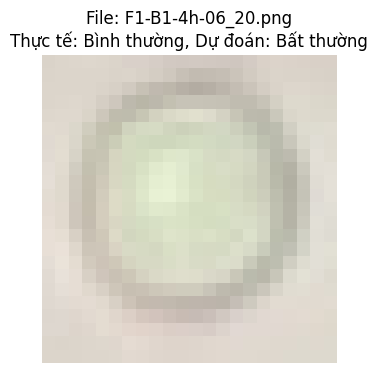

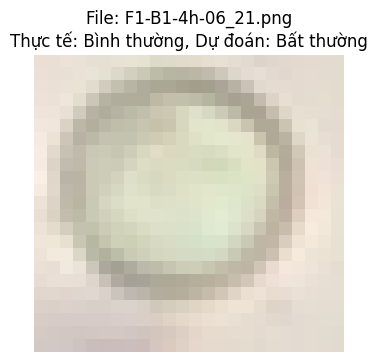

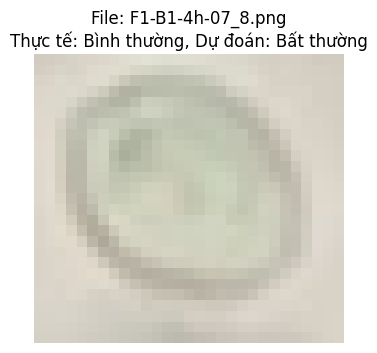

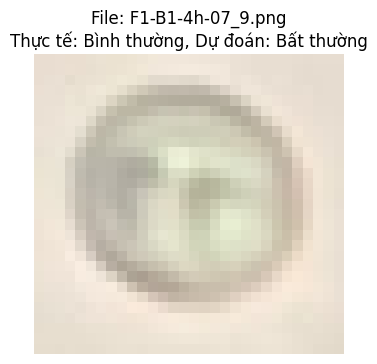

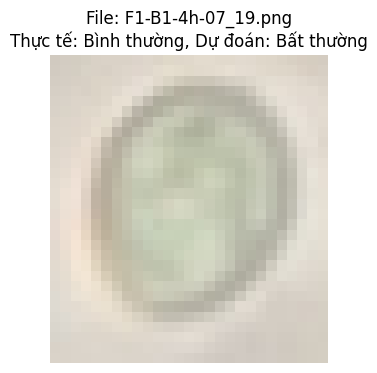

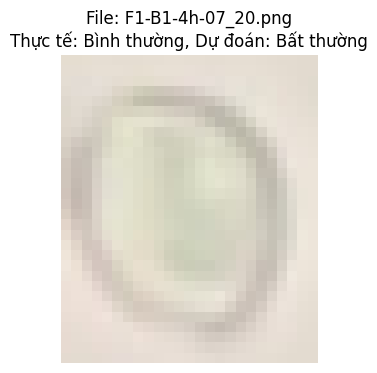

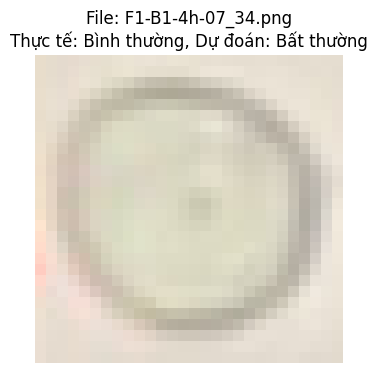

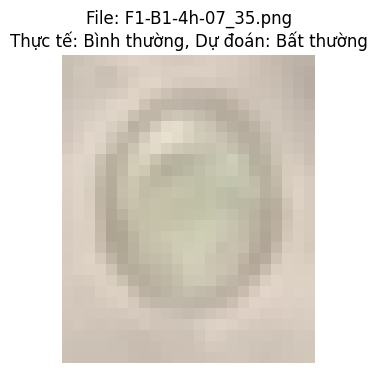

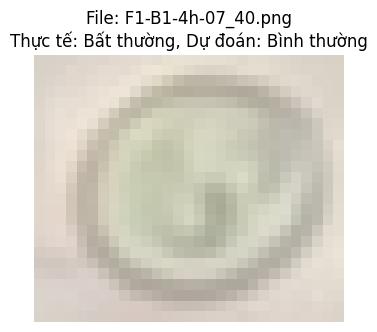

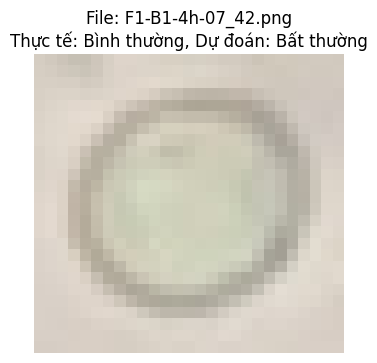

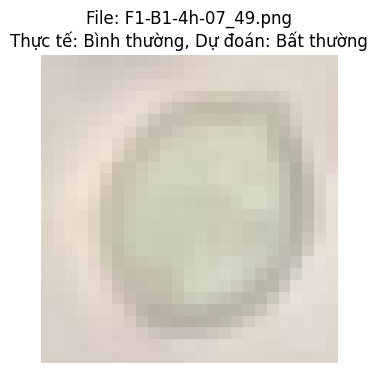

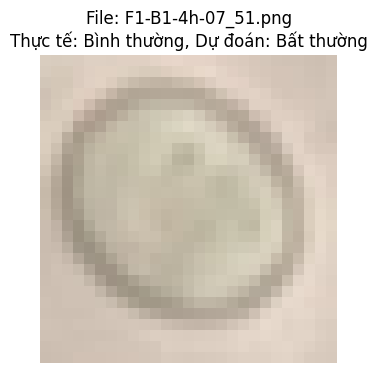

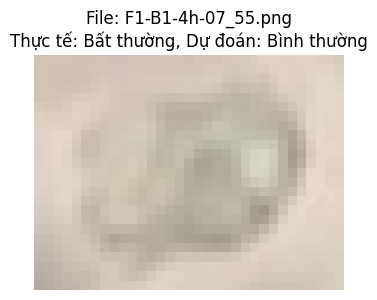

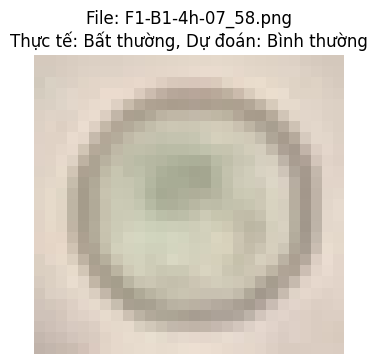

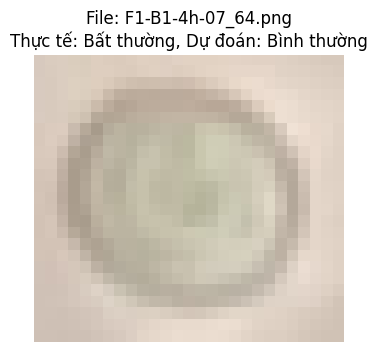

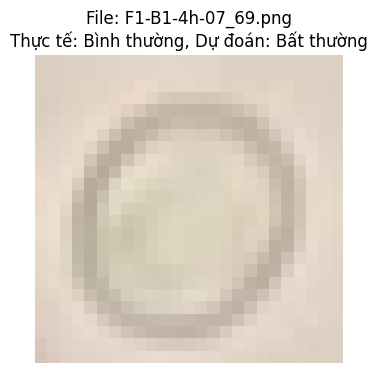

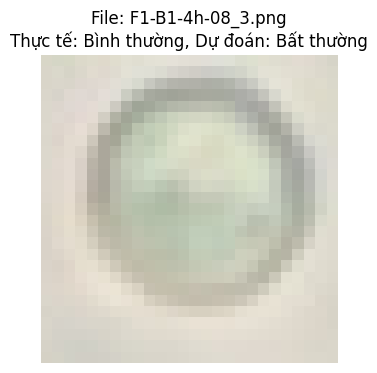

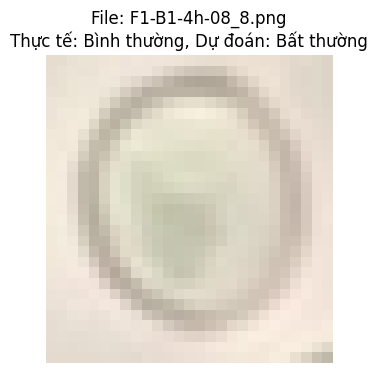

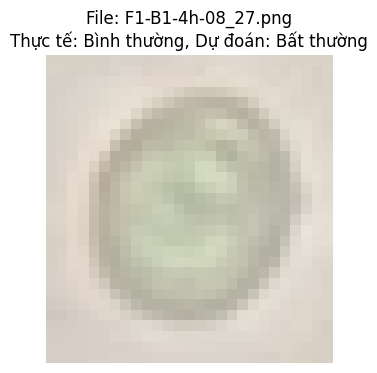

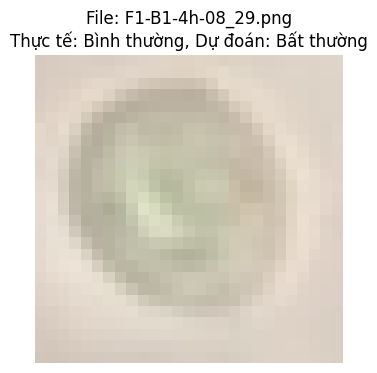

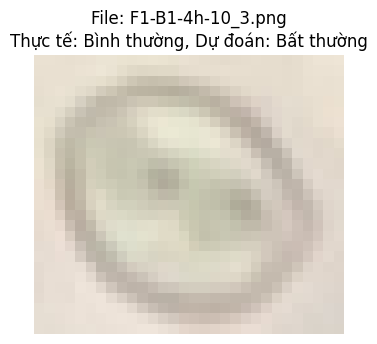

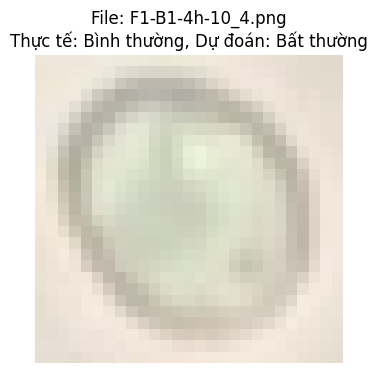

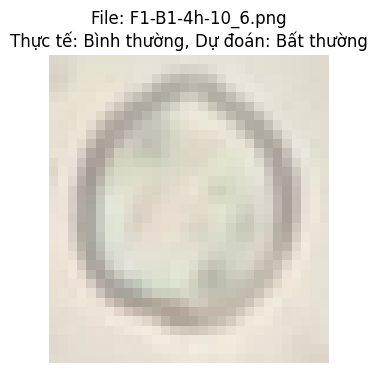

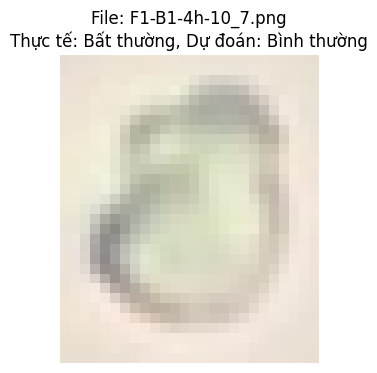

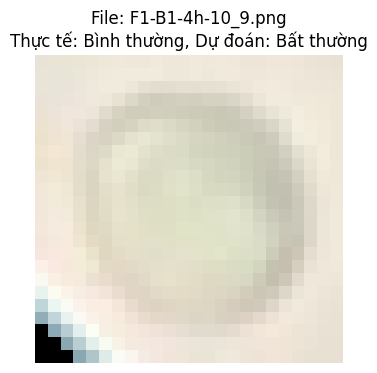

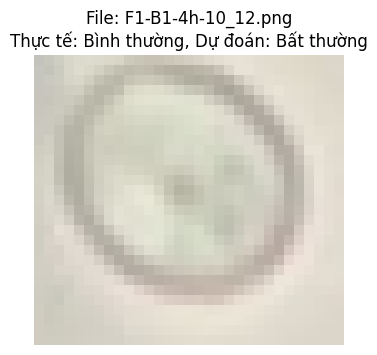

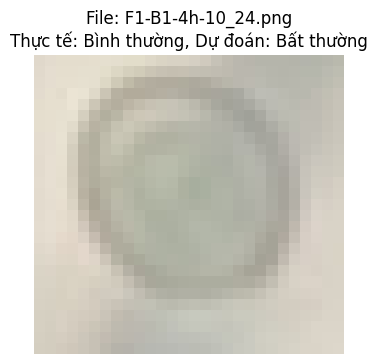

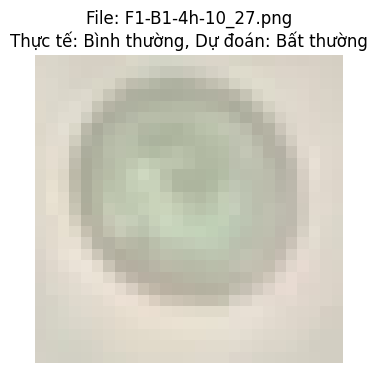

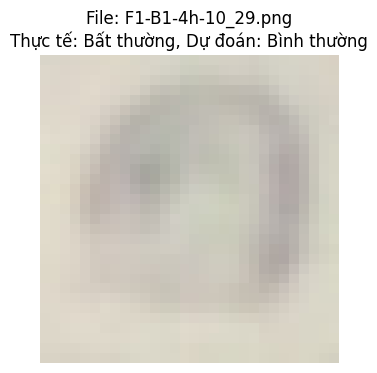

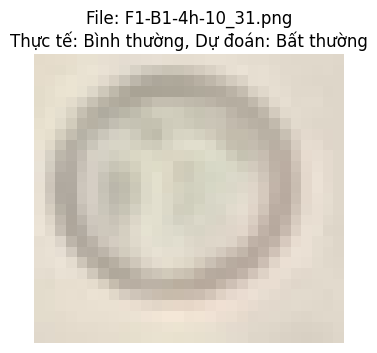

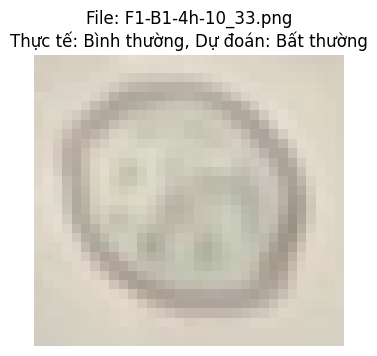

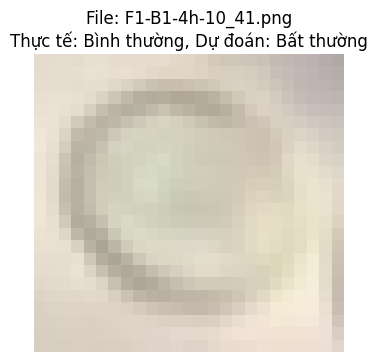

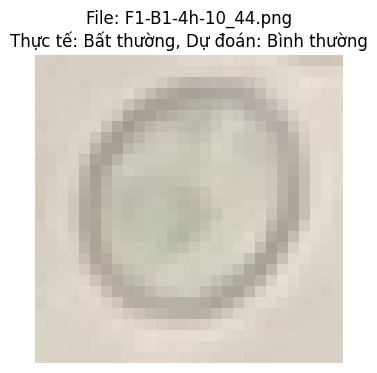

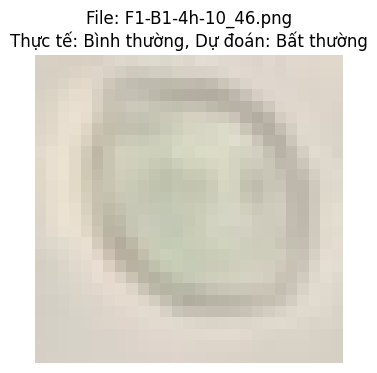

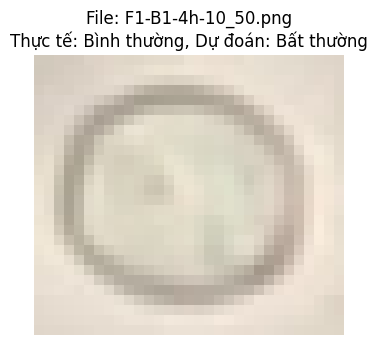

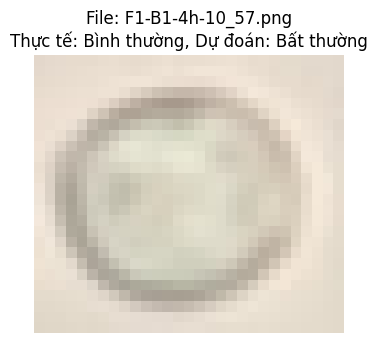

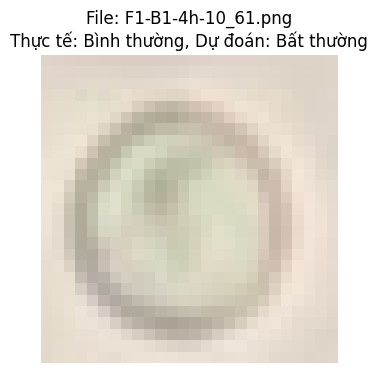

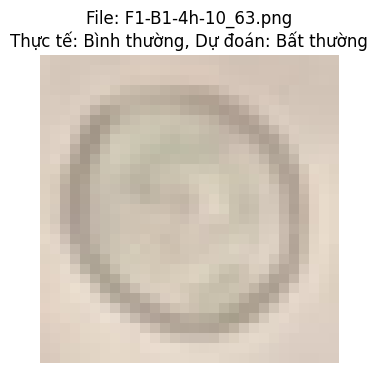

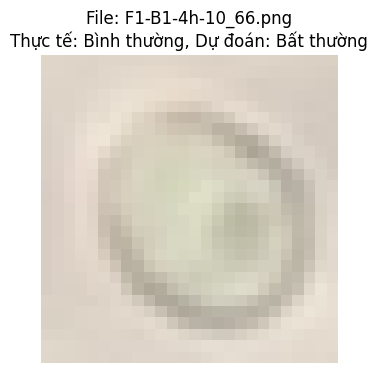

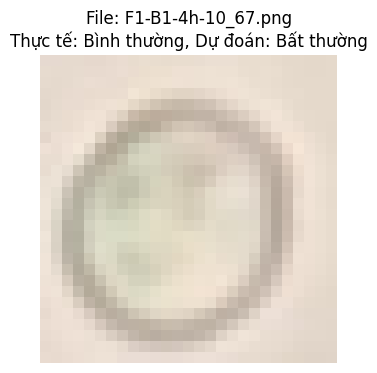

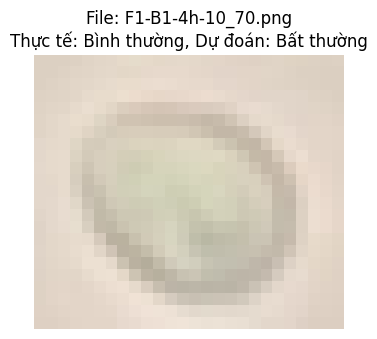

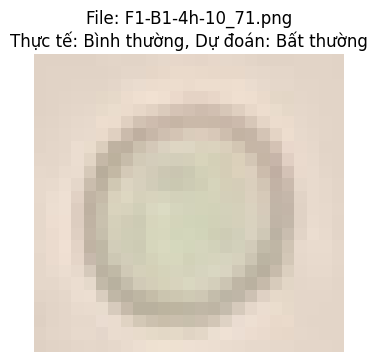

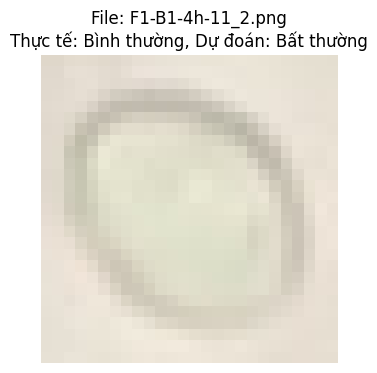

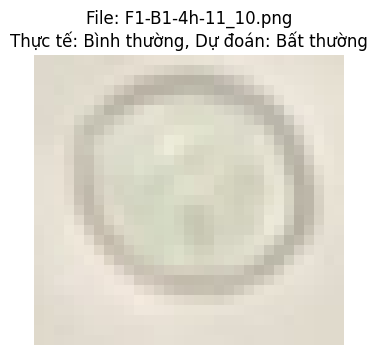

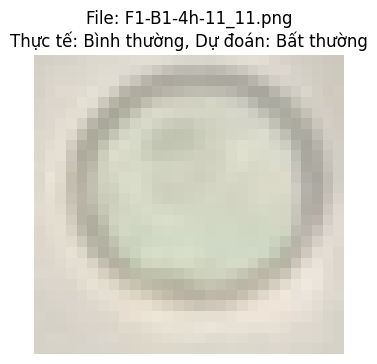

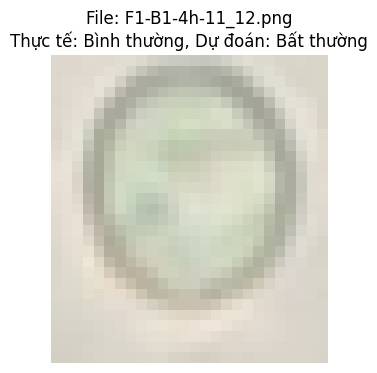

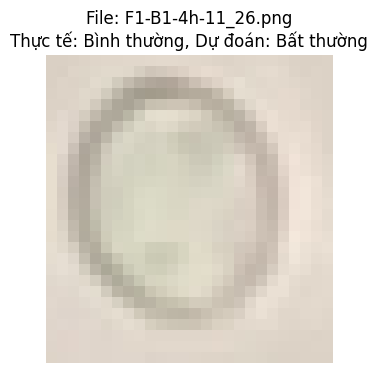

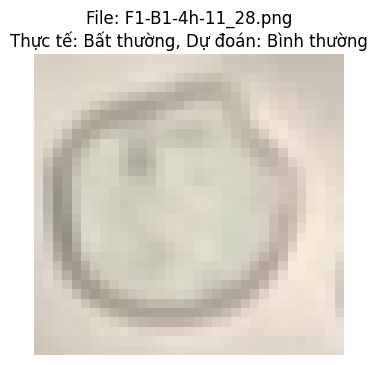

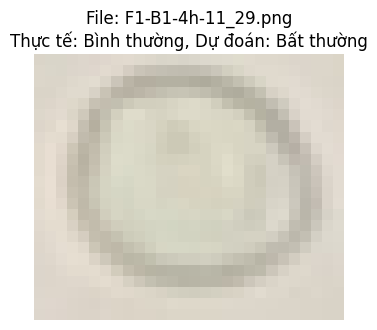

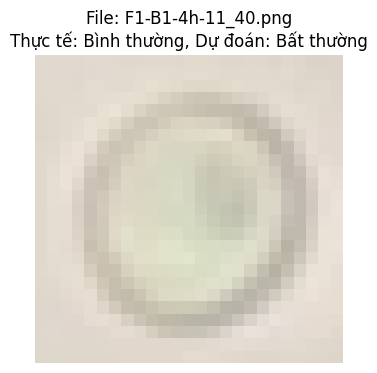

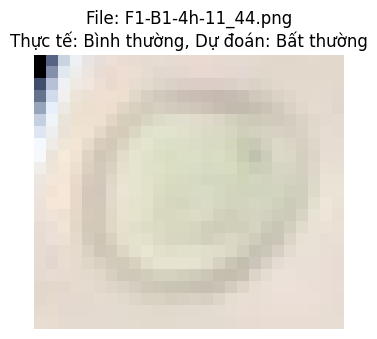

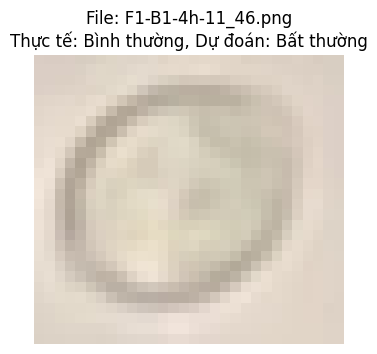

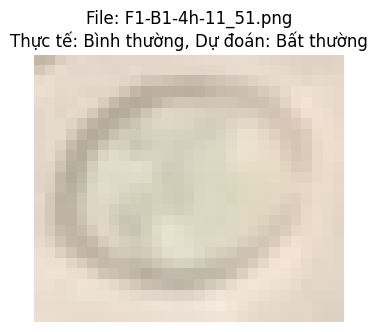

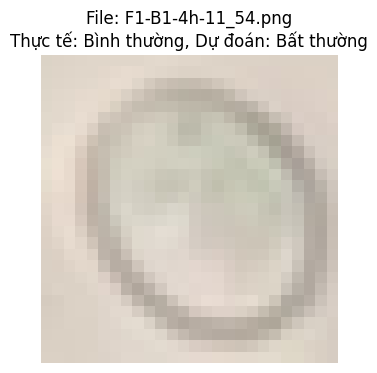

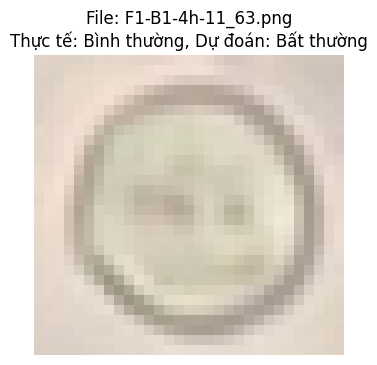

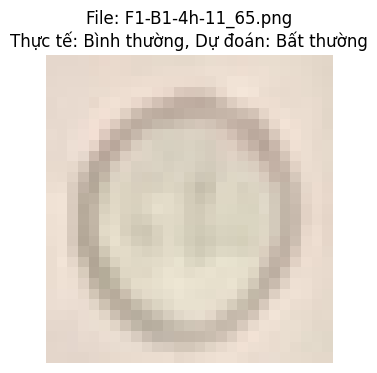

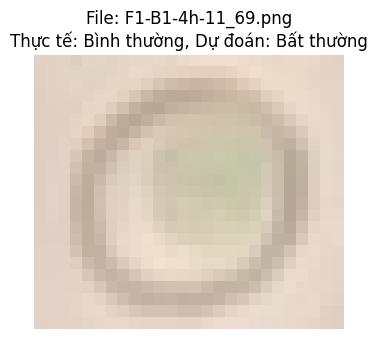

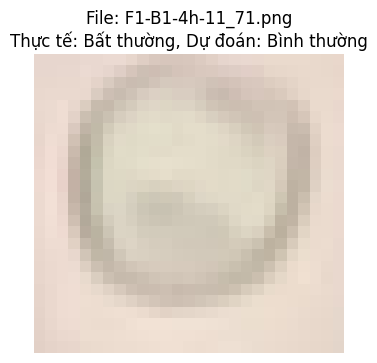

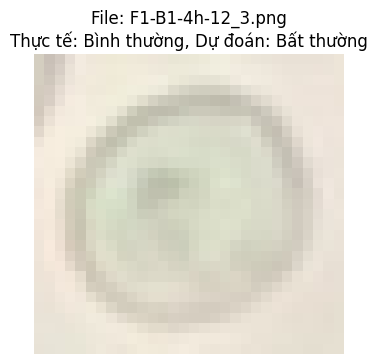

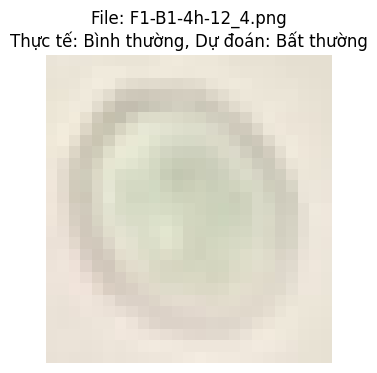

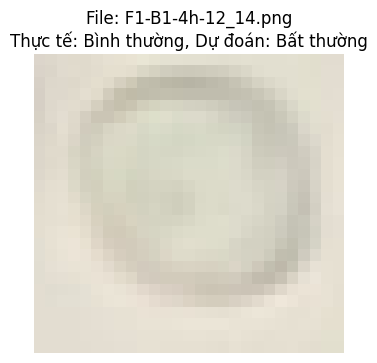

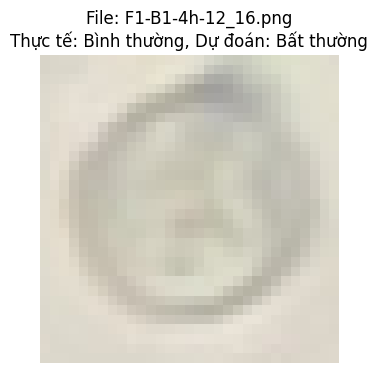

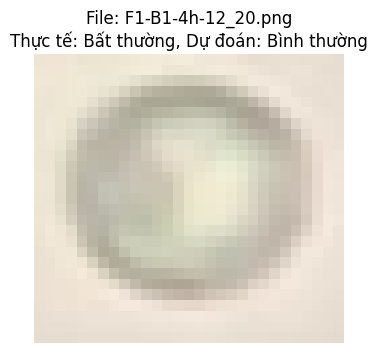

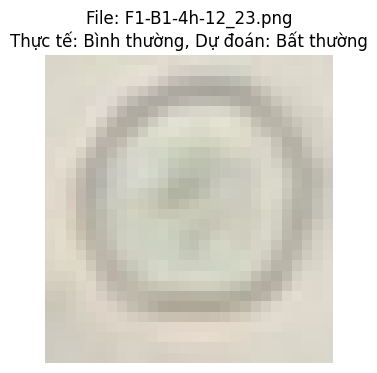

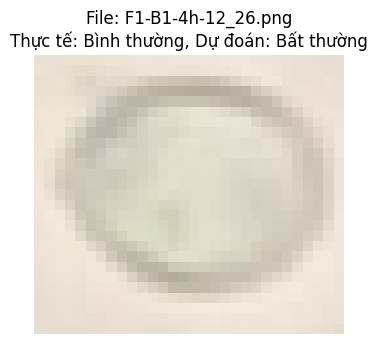

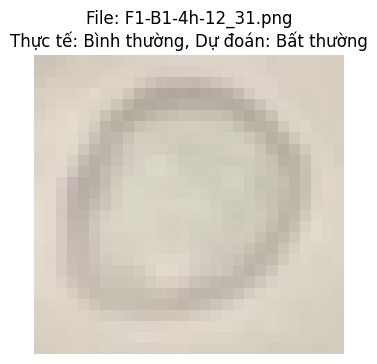

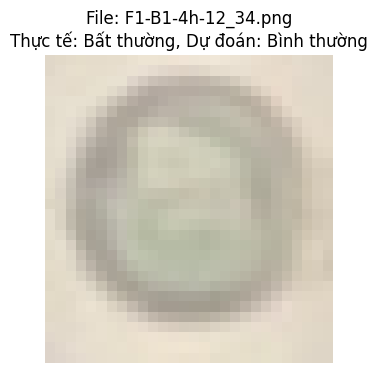

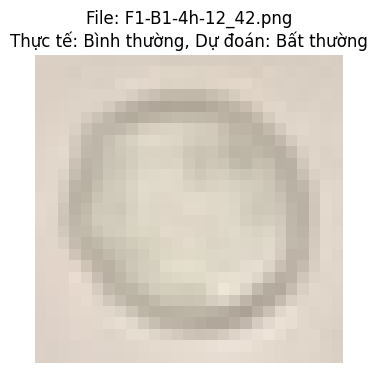

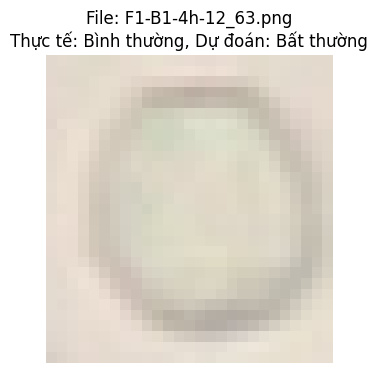

In [153]:
import matplotlib.pyplot as plt
import os
from PIL import Image

model.eval()  # Đảm bảo mô hình ở chế độ eval

incorrect_images = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = outputs.max(dim=1)  # Lấy lớp dự đoán (0 hoặc 1)

        for j in range(len(labels)):
            if preds[j] != labels[j]:
                # Tính chỉ số toàn cục (index) trong Dataset
                sample_idx = i * test_loader.batch_size + j

                # Lấy đường dẫn ảnh và label thật từ test_dataset
                img_path, real_label = test_loader.dataset.pairs[sample_idx]

                # Dự đoán
                predicted_label = preds[j].item()

                # Chuyển label số thành chuỗi
                real_label_str = "Bình thường" if real_label == 0 else "Bất thường"
                pred_label_str = "Bình thường" if predicted_label == 0 else "Bất thường"

                # Mở ảnh
                img = Image.open(img_path).convert("RGB")

                # Hiển thị bằng matplotlib
                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                # Ghi chú gồm tên file (hoặc đường dẫn), label thật, label dự đoán
                plt.title(f"File: {os.path.basename(img_path)}\n"
                          f"Thực tế: {real_label_str}, Dự đoán: {pred_label_str}")
                plt.axis("off")
                plt.show()
